In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/variant_types'

In [2]:
from os.path import join, exists, dirname
import os
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

from src.external.pyvenn import venn

%load_ext autoreload
%autoreload 2
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df

fig_utils from mplh
0.5.6


In [3]:
#dat_indir="data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.01/numC100000_ispropFalse/"
vars_type_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/anno_variants/varsType.tsv"
mult_dir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/vars_type"
#OUTDIR= "data/CHIP_april08_2021/MTblacklist/chrM/pseudo/minC200_minAF0.01/numC100000_ispropFalse/variants"

N_DONORS=5 
vars_to_plot=50
#dat_indir=""
sample_names="Control,Flt3l,Input"
n_clones=20

In [4]:
pd.read_csv(vars_type_f,sep='\t', index_col=0)

,#CHROM,POS,REF,ALT,QUAL,FILTER,INFO,variant type,variant change
ID,,,,,,,,,
58T>C,chrM,58,T,C,.,.,.,Transition,T>C
64C>T,chrM,64,C,T,.,.,.,Transition,C>T
146T>C,chrM,146,T,C,.,.,.,Transition,T>C
150C>T,chrM,150,C,T,.,.,.,Transition,C>T
152T>C,chrM,152,T,C,.,.,.,Transition,T>C
...,...,...,...,...,...,...,...,...,...
16311T>C,chrM,16311,T,C,.,.,.,Transition,T>C
16311T>G,chrM,16311,T,G,.,.,.,Transversion,T>G
16387A>G,chrM,16387,A,G,.,.,.,Transition,A>G


In [5]:
dat_indir = os.path.dirname(mult_dir)#, "multiplex")
out_f = os.path.join(outdir, f"variants_violin_top{vars_to_plot}")

In [6]:
sample_names = {ind:val for ind,val in enumerate(sample_names.split(","))}
#if not os.path.exists(OUTDIR):
#    os.mkdir(OUTDIR)
cells_meta = pd.read_csv(join(mult_dir, "cells_meta.tsv"), sep='\t')
cells_meta=cells_meta.astype({"donor_index": "Int64", "donor": "Int64"})
cells_meta.head()

,index,ID,raw ID,new index,condition,donor,donor_index
0,0,AAACGAAAGAATCAAC-1_Control,AAACGAAAGAATCAAC-1,1,Control,0,1
1,1,AAACGAAAGAATCAGT-1_Control,AAACGAAAGAATCAGT-1,2,Control,1,1
2,2,AAACGAAAGCATACCT-1_Control,AAACGAAAGCATACCT-1,3,Control,1,2
3,3,AAACGAAAGCGAGAAA-1_Control,AAACGAAAGCGAGAAA-1,4,Control,0,2
4,4,AAACGAAAGTACAGAT-1_Control,AAACGAAAGTACAGAT-1,5,Control,0,3


## Load and clean variants vcf

In [7]:
dat_indir

'/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn'

In [8]:
vcf = pd.read_csv(join(dat_indir, "cellSNP.base.vcf"),sep='\t')
vcf_samp_dict = {}
for s in sample_names:
    col = vcf.columns.values[vcf.columns.str.contains(sample_names[s])]
    vcf_samp_dict[col[0]]=sample_names[s]
vcf = vcf.rename(vcf_samp_dict, axis=1)
vcf

,#CHROM,POS,REF,ALT,strand_correlation_x,vmr_x,n_cells_over_5_x,n_cells_over_20_x,index,Control,...,vmr_y,n_cells_over_5_y,n_cells_over_20_y,Flt3l,strand_correlation,vmr,n_cells_over_5,n_cells_over_20,Input,new ID
0,chrM,58,58T,C,0.918491,0.474105,2373.0,2235.0,58T>C,1.0,...,0.298145,3987.0,3821.0,1.0,0.904301,0.465437,3882.0,3843.0,1.0,1
1,chrM,64,64C,T,0.913438,0.496710,2359.0,2227.0,64C>T,2.0,...,0.314928,3942.0,3783.0,2.0,0.897911,0.480897,3879.0,3844.0,2.0,2
2,chrM,146,146T,C,0.797828,0.371941,2235.0,2175.0,146T>C,3.0,...,0.195844,3664.0,3575.0,3.0,0.715963,0.442567,3892.0,3857.0,4.0,3
3,chrM,150,150C,T,0.784094,0.291894,2770.0,2723.0,150C>T,4.0,...,0.216110,3212.0,3166.0,4.0,0.765736,0.491712,2929.0,2895.0,5.0,4
4,chrM,152,152T,C,0.889834,0.576488,22.0,19.0,152T>C,5.0,...,NaN,NaN,NaN,NaN,0.867155,0.815522,47.0,40.0,6.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,chrM,16311,16311T,C,NaN,NaN,NaN,NaN,16311T>C,NaN,...,NaN,NaN,NaN,NaN,0.990682,0.356352,20.0,9.0,220.0,227
227,chrM,16311,16311T,G,NaN,NaN,NaN,NaN,16311T>G,NaN,...,NaN,NaN,NaN,NaN,0.683130,0.041748,4.0,0.0,221.0,228
228,chrM,16387,16387A,G,NaN,NaN,NaN,NaN,16387A>G,NaN,...,NaN,NaN,NaN,NaN,0.714659,0.042715,52.0,0.0,224.0,229
229,chrM,16519,16519T,G,NaN,NaN,NaN,NaN,16519T>G,NaN,...,NaN,NaN,NaN,NaN,1.000000,0.045610,3.0,0.0,225.0,230


<AxesSubplot:xlabel='variant type', ylabel='count'>

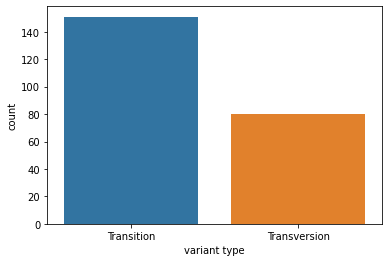

In [9]:
%matplotlib inline
vcf['ID'] = vcf.fillna("N").apply(lambda x: str(x["POS"]) + x['REF']+">"+x['ALT'], axis=1)

variant_df = vu.type_of_variants(vcf['ID'].values)
variant_positions = list(map(lambda x: int(x[:-3]), vcf['ID']))
variant_df["ID"] = np.arange(len(variant_df))

sns.countplot(x=variant_df['variant type'])

## Get overlap variants based on the vireo algorithm

## Plot

In [10]:
samples = list(sample_names.values())
variant_overlaps=dict()
for s in samples:
    variant_overlaps[s] = set(vcf[s].loc[(~(vcf[s].isnull()))].index.values)

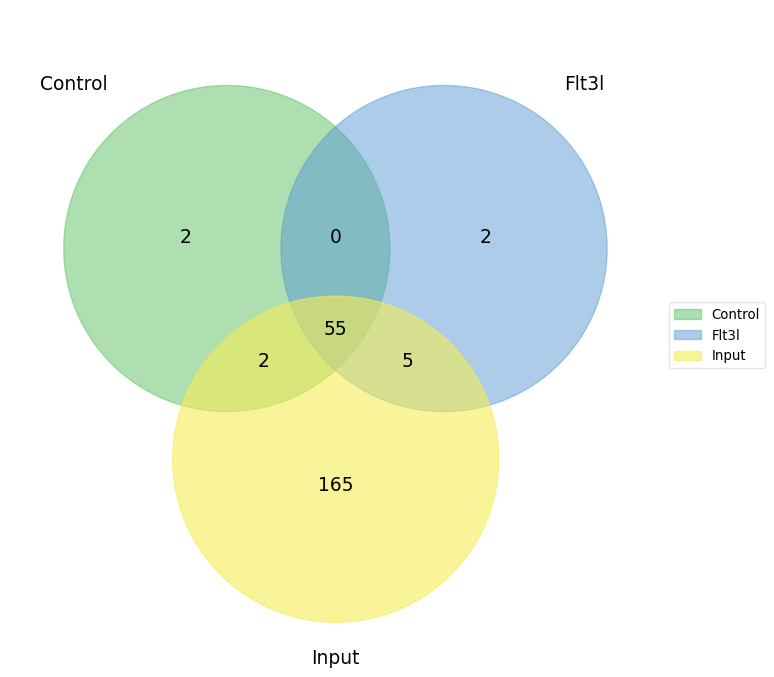

In [11]:
%matplotlib inline
labels=venn.get_labels(list(variant_overlaps.values()))
if len(samples) == 2:
    venn.venn2(labels=labels ,names=samples)
elif len(samples) == 3:
    venn.venn3(labels=labels ,names=samples)
elif len(samples) == 4:
    venn.venn4(labels=labels ,names=samples)
else: "Too many conditions to plot overlaps"

## Break up by donor and plot

### Load AD , DP  and convert variants to dense

In [12]:
# ad, dp = wrap_load_mtx_df(dat_indir, oth_f=False, prefix="cellSNP.tag",
#                      columns=('Variant', 'Cell', 'integer'))

AF_df, DP_df = wrap_load_mtx_df(dat_indir, oth_f=False, prefix="cellSNP.tag",
                     columns=('Variant', 'Cell', 'integer'), inc_af=True, as_dense=True, var_names=True)

variant_df = vu.type_of_variants(AF_df.index)

variants_box=vu.variants_dense(AF_df, vars_to_plot, samples_d=cells_meta['condition'], donors_d=cells_meta['donor'],
                              variant_d=variant_df['variant type'])
variants_box

ic| prefix: 'cellSNP.tag'


,Variant,Cell,AF,condition,donor,sqrtAF,variant type
0,310310T>C,0,0.730769,Control,0,0.854850,Transition
1,24422442T>C,0,0.875000,Control,0,0.935414,Transition
2,82928292G>A,0,0.866666,Control,0,0.930949,Transition
3,827827A>G,0,0.961538,Control,0,0.980580,Transition
4,1318813188C>T,0,1.000000,Control,0,1.000000,Transition
...,...,...,...,...,...,...,...
911645,19491949G>A,18232,0.000000,Input,0,0.000000,Transition
911646,1145311453G>A,18232,0.000000,Input,0,0.000000,Transition
911647,1529715297T>C,18232,0.000000,Input,0,0.000000,Transition
911648,26232623A>G,18232,0.000000,Input,0,0.000000,Transition


## Plots
### a. Line plot across conditions (top 50)
x = condition (ordered as first, last, middle  
y = mean AF (and variance?)  
column = donors


### b. Line plot across donors (top 50)
x=donors
y=mean af
columns=condition

### c. Transition-transversion violinplot meanAF each column is a donor


In [13]:
variants_box = variants_box.dropna() # removes the ambiguous donors

In [14]:
variants_box

,Variant,Cell,AF,condition,donor,sqrtAF,variant type
0,310310T>C,0,0.730769,Control,0,0.854850,Transition
1,24422442T>C,0,0.875000,Control,0,0.935414,Transition
2,82928292G>A,0,0.866666,Control,0,0.930949,Transition
3,827827A>G,0,0.961538,Control,0,0.980580,Transition
4,1318813188C>T,0,1.000000,Control,0,1.000000,Transition
...,...,...,...,...,...,...,...
911645,19491949G>A,18232,0.000000,Input,0,0.000000,Transition
911646,1145311453G>A,18232,0.000000,Input,0,0.000000,Transition
911647,1529715297T>C,18232,0.000000,Input,0,0.000000,Transition
911648,26232623A>G,18232,0.000000,Input,0,0.000000,Transition


In [16]:
if len(samples)<=2:
    order = samples
else:
    order = [samples[0], samples[-1]]+samples[1:-1]
colors={"Transition":"g", 'Transversion': 'b'}


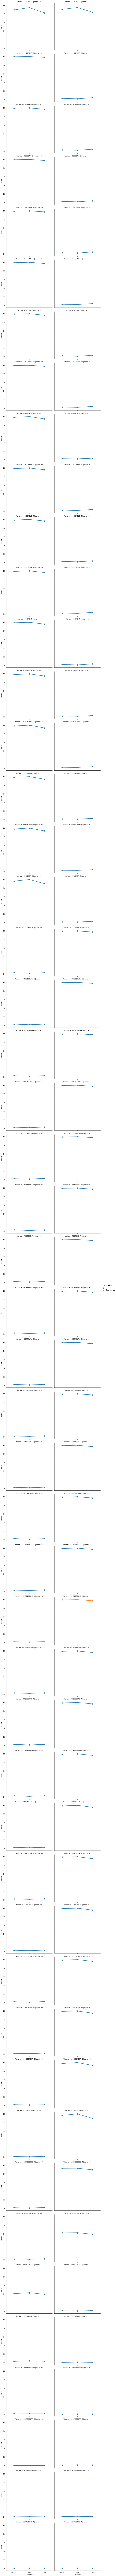

In [23]:
sns.catplot(row="Variant", col="donor", x='condition', y='sqrtAF', order=order, data=variants_box,
              hue="variant type", hue_order=["Transition", "Transversion"], kind='point')

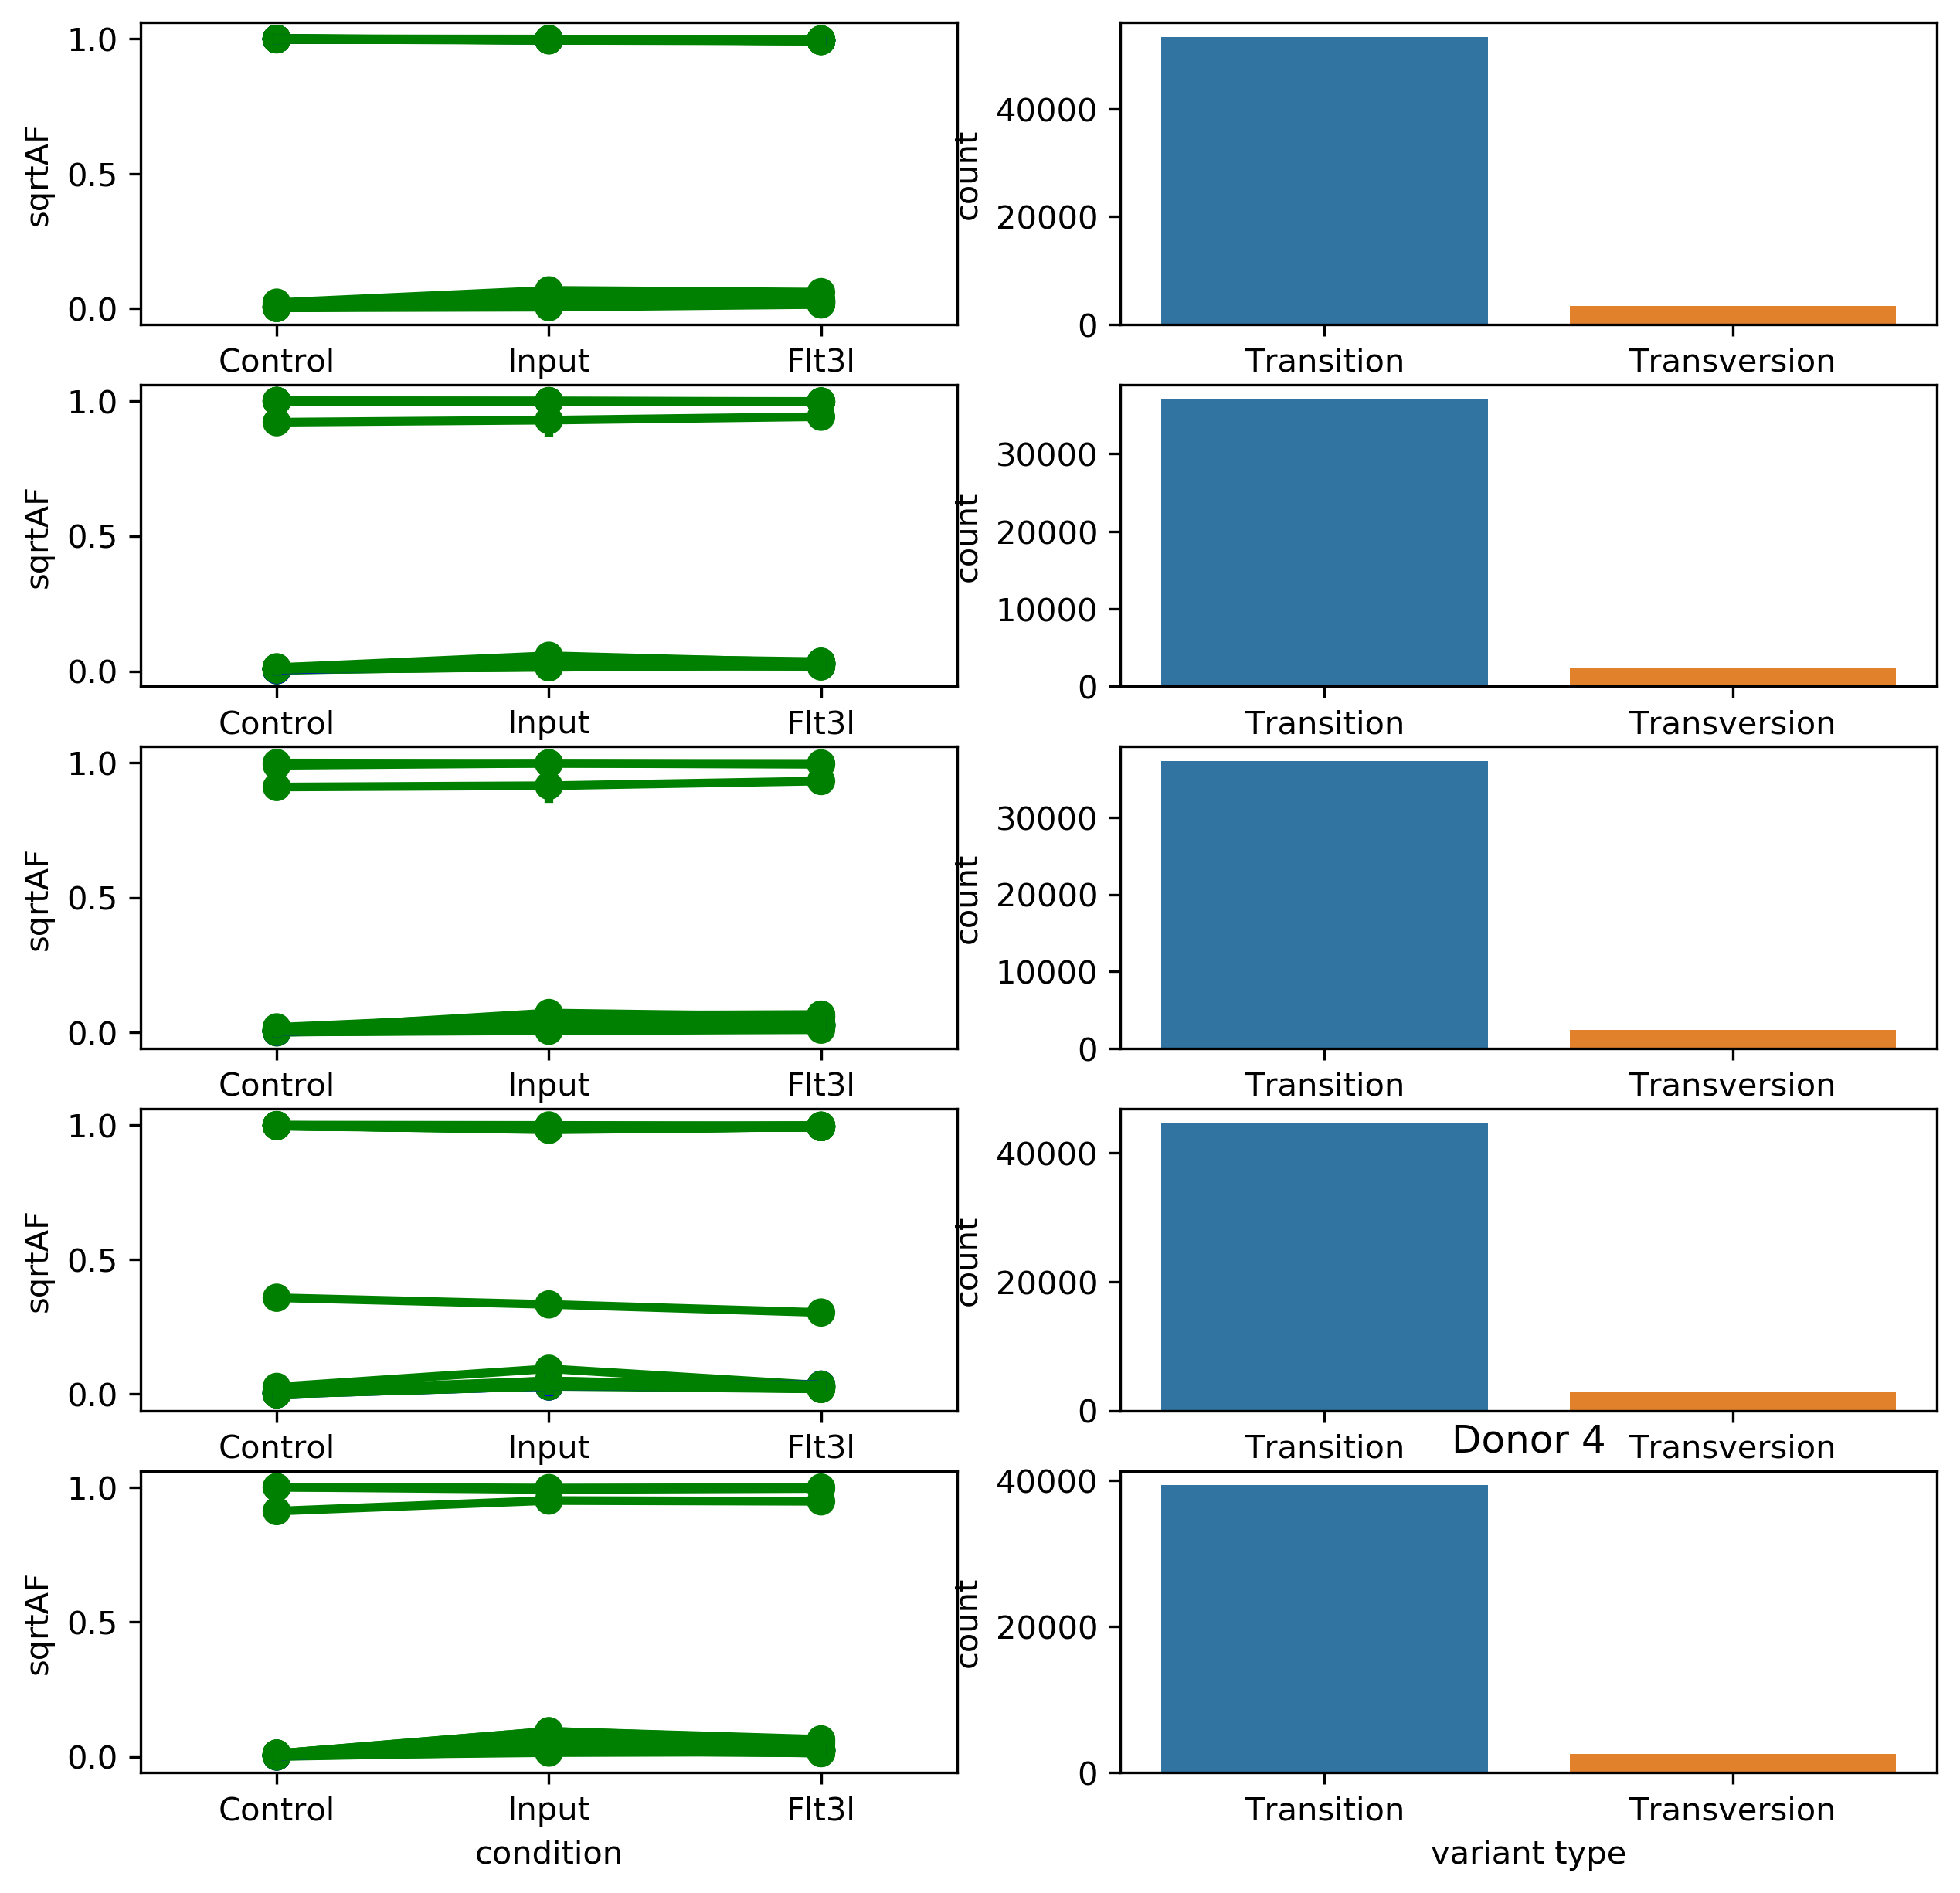

In [13]:
%matplotlib inline
#variants_box=variants_dense(AF_df, vars_to_plot)



f, ax = plt.subplots(len(set(variants_box['donor'])), 2, figsize=(10,10), dpi=300)
for d, df in variants_box.groupby("donor"):
    #f,ax = plt.subplots()
    for v, df2 in df.groupby("Variant"):
        sns.pointplot(x='condition', y='sqrtAF', order=order, data=df2, color=colors[df2["variant type"].iloc[0]],
                      ax=ax[d,0])
        sns.countplot(x=df['variant type'], ax=ax[d,1], order=["Transition", "Transversion"], )
        
        #ax.legend().set_visible(False)

    plt.title(f"Donor {d}")

### Without input

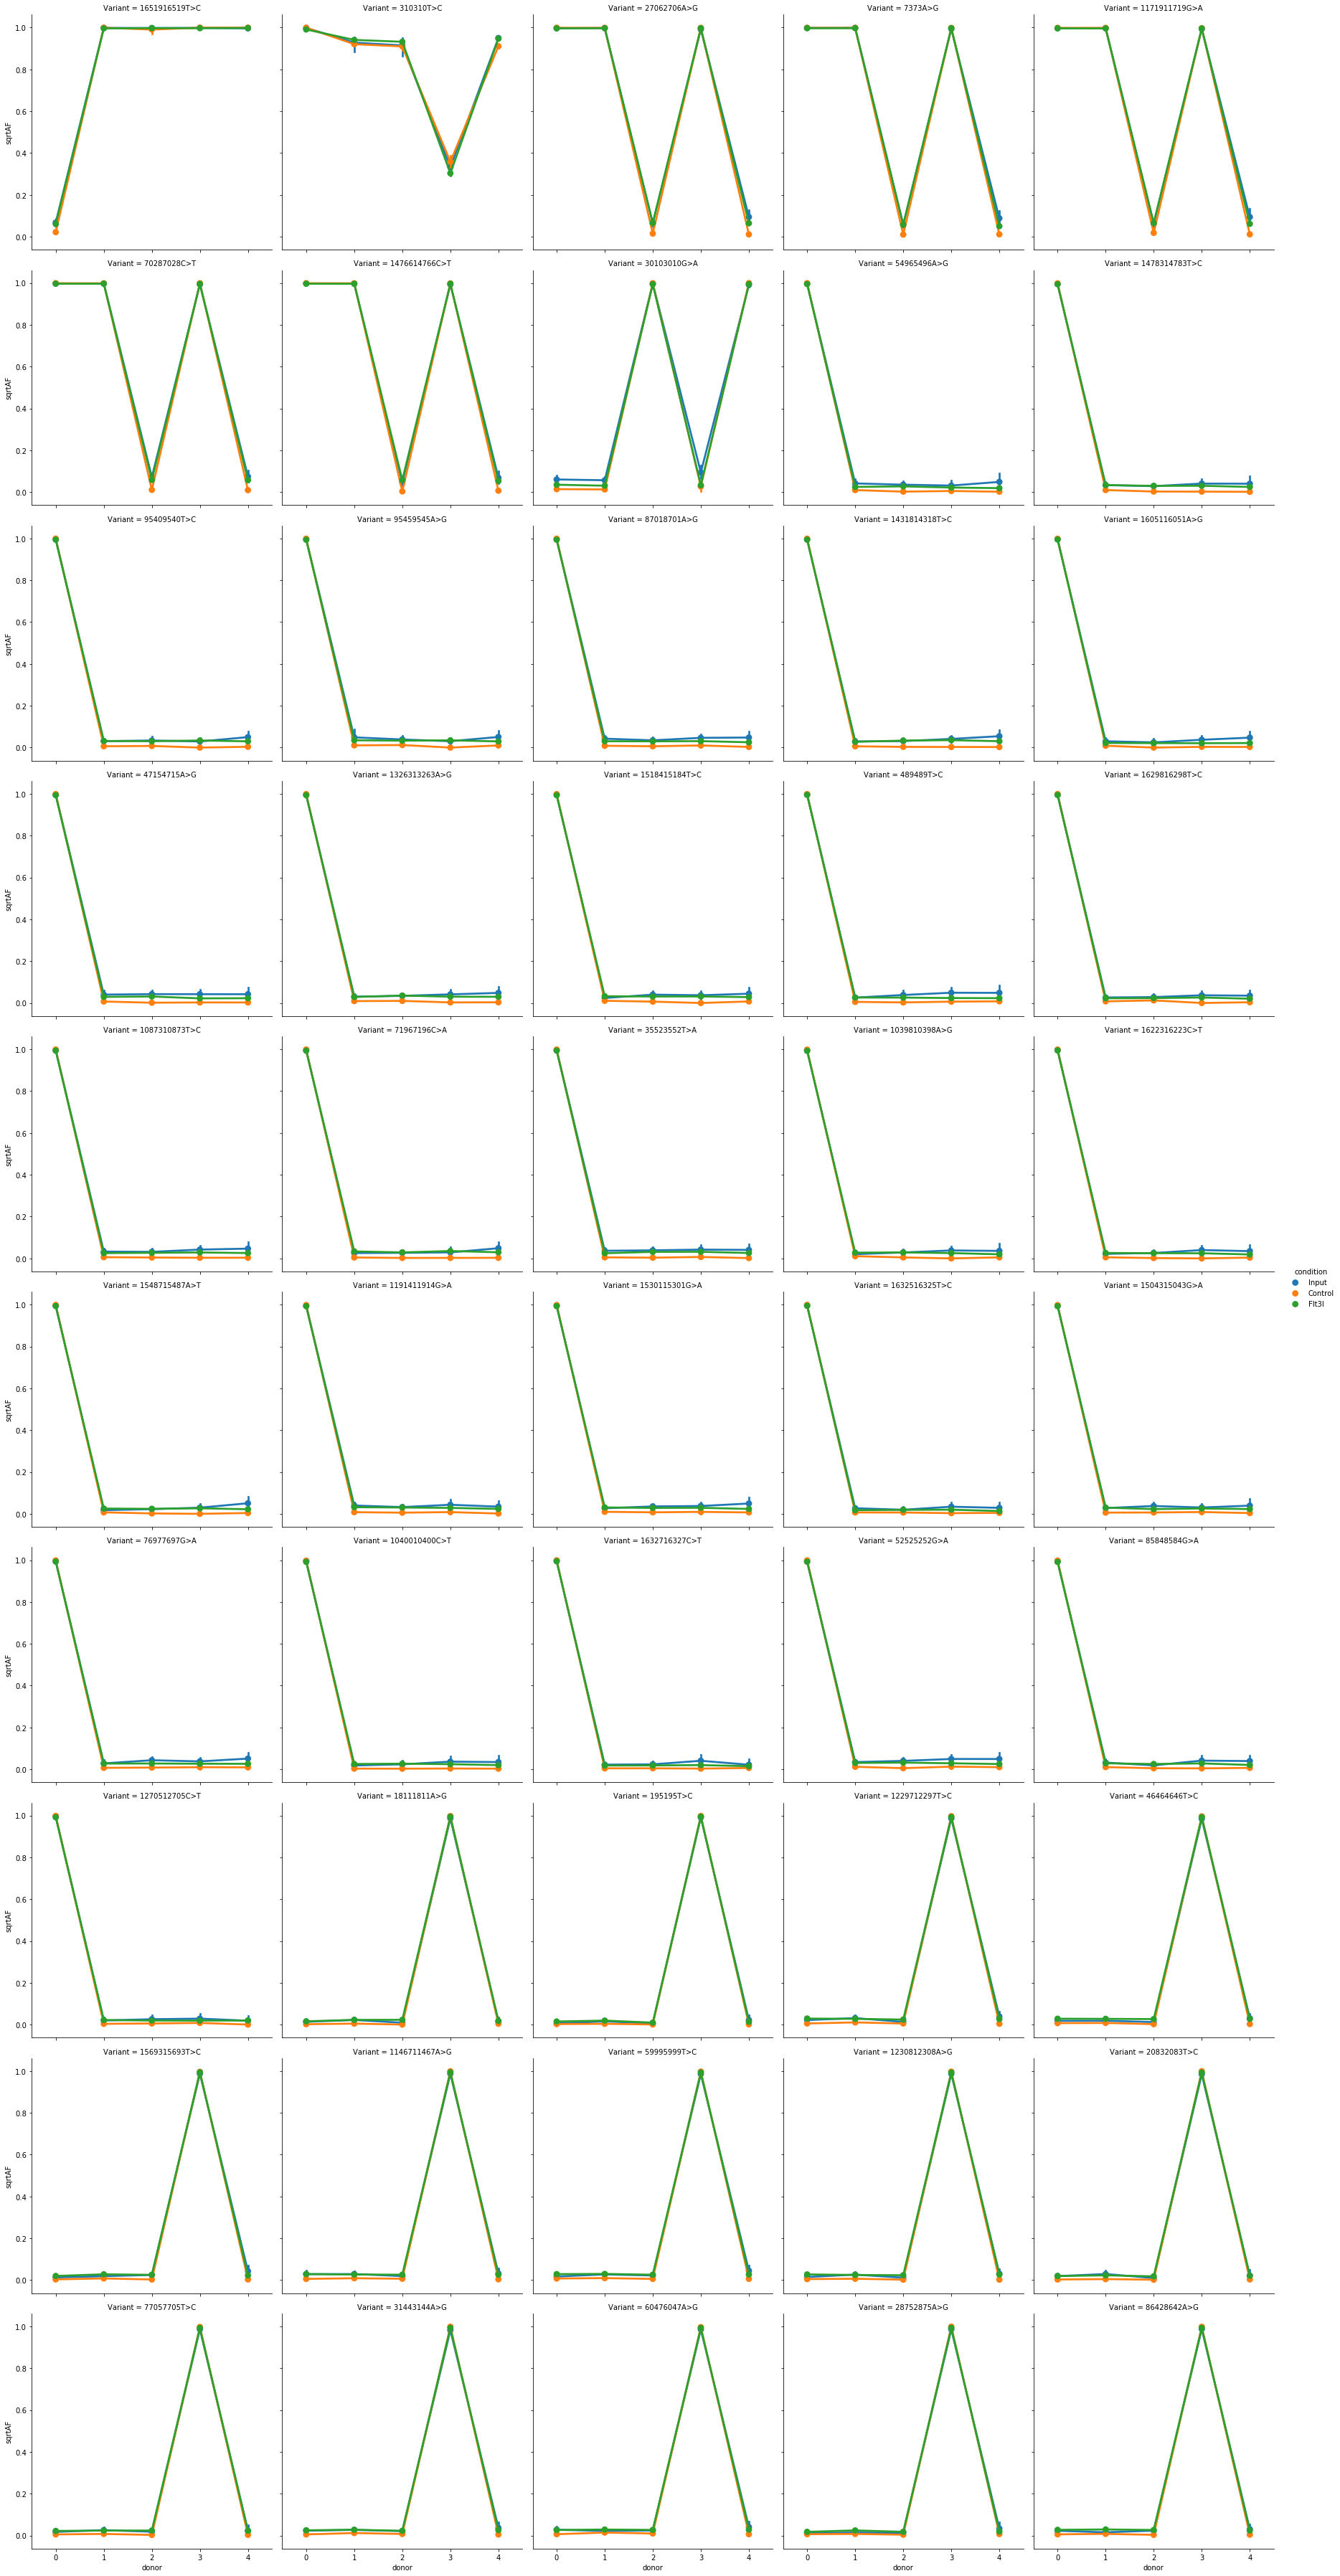

In [15]:
g = sns.catplot(x='donor', y='sqrtAF', 
                hue='condition', col='Variant',col_wrap=5, 
                data=variants_box, 
                kind="point", bw=.2)


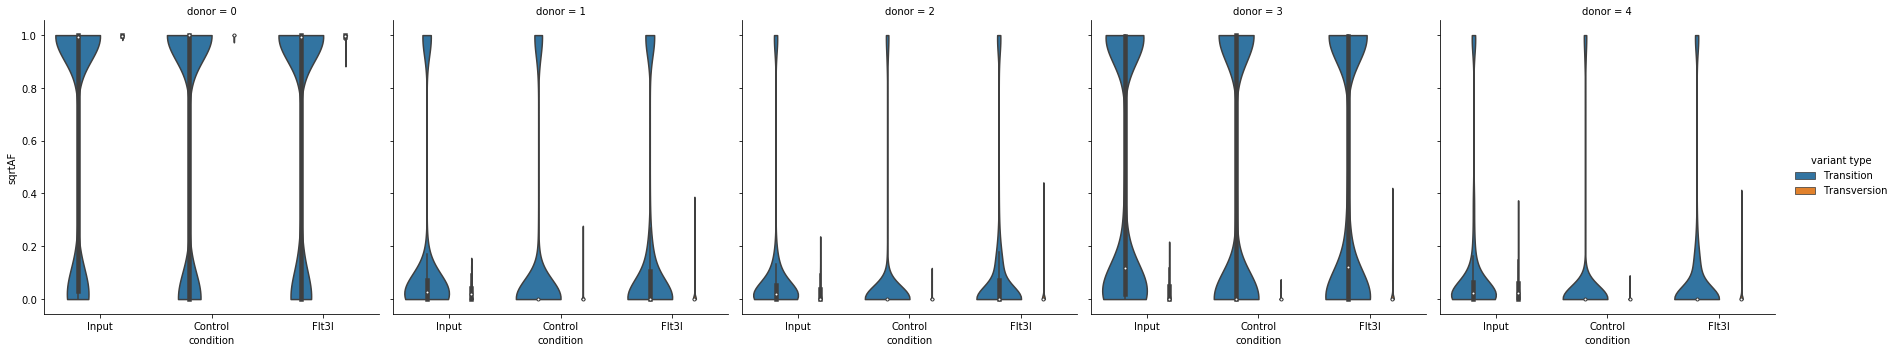

In [16]:
%matplotlib inline
#variants_box=variants_dense(AF_df, vars_to_plot)

g = sns.catplot(x='condition', y='sqrtAF', 
                hue='variant type', col='donor',col_wrap=5, 
                data=variants_box, 
                kind="violin", dodge=True, cut=0, bw=.2, scale="count")
